In [62]:
import torch
from torch import nn
from torch.distributions.normal import Normal
from torch.distributions.categorical import Categorical
import matplotlib.pyplot as plt
import yaml
import gymnasium as gym
import numpy as np

In [63]:
class Actor(nn.Module):
    def __init__(self, obs_dim, action_dim, hidden_layers = [128,128], std_clamp_min = -12, std_clamp_max = 2, discrete = False, action_range = 1):
        super(Actor, self).__init__()
        self.action_dim = action_dim
        self.clamp_min = std_clamp_min
        self.clamp_max = std_clamp_max
        self.action_range = action_range
        self.is_discrete = discrete
        
        self.head = nn.Linear(obs_dim, hidden_layers[0])
        self.hidden_layer = nn.ModuleList([nn.Linear(hidden_layers[i], hidden_layers[i+1]) for i in range(len(hidden_layers)-1)])
        if self.is_discrete:
            self.tail = nn.Linear(hidden_layers[-1], action_dim)
        else:
            self.tail = nn.Linear(hidden_layers[-1], action_dim * 2)
        self.relu = nn.ReLU()

    def forward(self, state):
        x = self.head(state)
        y = self.relu(x)
        for layer in self.hidden_layer:
            y = layer(y)
            y = self.relu(y)
        x = self.tail(y)

        if self.is_discrete:
            distribution = Categorical(logits = x)
        else:
            distribution = Normal(x[:,:self.action_dim], torch.exp(torch.clamp(x[:,self.action_dim:], self.clamp_min, self.clamp_max)))

        actions = distribution.sample()
        log_probs = distribution.log_prob(actions)
        
        if not self.is_discrete:
            actions = self.action_range * torch.tanh(actions)
            log_probs -= torch.log(self.action_range * (1 - (actions / self.action_range).pow(2) + 1e-6)).sum(dim=-1, keepdim=True)

        return y,actions

In [64]:
agent_file = 'Pendulum.pt'
agent_params_file = "hyperparameters.yml"

with open(agent_params_file, 'r') as f:
    hyperparams = yaml.safe_load(f)

env = gym.make(hyperparams['env_name'])
obs_dim = env.observation_space.shape[0]
discrete = isinstance(env.action_space, gym.spaces.Discrete)
if discrete:
    action_dim = env.action_space.n
    action_range = action_dim
else:
    action_dim = env.action_space.shape[0]
    action_range = torch.tensor(env.action_space.high)

actor = Actor(obs_dim, action_dim, hyperparams['actor_hidden'], hyperparams['std_clamp_min'], hyperparams['std_clamp_max'], discrete, action_range)
actor.load_state_dict(torch.load(agent_file, weights_only=True))


<All keys matched successfully>

In [69]:
precision = 1000

theta = np.linspace(0,2 * np.pi,precision)
angular_velocity = np.linspace(-8,8,precision)
state = []
t = []
v = []
for temp_theta in theta:
    for temp_vel in angular_velocity:
        state.append(torch.tensor([np.cos(temp_theta), np.sin(temp_theta), temp_vel], dtype = torch.float32))
        t.append(temp_theta)
        v.append(temp_vel)
state = torch.stack(state)
print(state.shape)

torch.Size([1000000, 3])


In [70]:
with torch.no_grad():
    y, actions = actor(state)

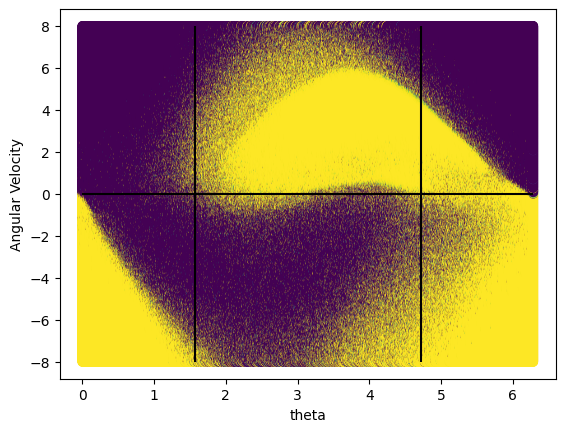

In [72]:
colors = (actions + 2.0) * 255.0 / 4.0
plt.scatter(t, v, c=colors, cmap='viridis')
plt.vlines(np.pi / 2, -8,8, colors = 'black')
plt.vlines(3 * np.pi / 2, -8,8, colors = 'black')
plt.xlabel("theta")
plt.ylabel("Angular Velocity")
plt.hlines(0,0,2 * np.pi, colors='black')